# AutoGluon - Combining BERT/Transformers and Classical Tabular Models

Here we introduce how to use AutoGluon Tabular to deal with multimodal tabular data that contains text, numeric, and categorical columns. In AutoGluon, **raw text data** is considered as a first-class citizen of data tables. AutoGluon Tabular can help you train and combine a diverse set of models including classical tabular models like LightGBM/RF/CatBoost as well as our pretrained NLP model based multimodal network that is introduced in the previous notebook.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pprint
import random
from autogluon.tabular import TabularPredictor
import mxnet as mx

np.random.seed(123)
random.seed(123)
mx.random.seed(123)

## Product Sentiment Analysis Dataset

We consider the product sentiment analysis dataset from a [MachineHack hackathon](https://www.machinehack.com/hackathons/product_sentiment_classification_weekend_hackathon_19/leaderboard). The goal is to predict a user's sentiment towards a product given their review (raw text) and a categorical feature indicating the product's type (e.g., Tablet, Mobile, etc.). We have already split the original dataset to be 90% for training and 10% for development/testing (if submitting your models to the hackathon, we recommend training them on 100% of the dataset).

In [2]:
!mkdir -p product_sentiment_machine_hack
!wget https://autogluon-text-data.s3.amazonaws.com/multimodal_text/machine_hack_product_sentiment/train.csv -O product_sentiment_machine_hack/train.csv
!wget https://autogluon-text-data.s3.amazonaws.com/multimodal_text/machine_hack_product_sentiment/dev.csv -O product_sentiment_machine_hack/dev.csv
!wget https://autogluon-text-data.s3.amazonaws.com/multimodal_text/machine_hack_product_sentiment/test.csv -O product_sentiment_machine_hack/test.csv

--2021-03-28 19:25:53--  https://autogluon-text-data.s3.amazonaws.com/multimodal_text/machine_hack_product_sentiment/train.csv
Resolving autogluon-text-data.s3.amazonaws.com (autogluon-text-data.s3.amazonaws.com)... 52.217.69.36
Connecting to autogluon-text-data.s3.amazonaws.com (autogluon-text-data.s3.amazonaws.com)|52.217.69.36|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 689486 (673K) [text/csv]
Saving to: ‘product_sentiment_machine_hack/train.csv’

product_sentiment_m 100%[===================>] 673.33K  --.-KB/s    in 0.006s  

2021-03-28 19:25:53 (110 MB/s) - ‘product_sentiment_machine_hack/train.csv’ saved [689486/689486]

--2021-03-28 19:25:54--  https://autogluon-text-data.s3.amazonaws.com/multimodal_text/machine_hack_product_sentiment/dev.csv
Resolving autogluon-text-data.s3.amazonaws.com (autogluon-text-data.s3.amazonaws.com)... 52.217.69.36
Connecting to autogluon-text-data.s3.amazonaws.com (autogluon-text-data.s3.amazonaws.com)|52.217.69.36|:443

In [3]:
subsample_size = 2000  # for quick demo, try setting to larger values
feature_columns = ['Product_Description', 'Product_Type']
label = 'Sentiment'

train_df = pd.read_csv('product_sentiment_machine_hack/train.csv', index_col=0).sample(2000, random_state=123)
dev_df = pd.read_csv('product_sentiment_machine_hack/dev.csv', index_col=0)
test_df = pd.read_csv('product_sentiment_machine_hack/test.csv', index_col=0)

train_df = train_df[feature_columns + [label]]
dev_df = dev_df[feature_columns + [label]]
test_df = test_df[feature_columns]
print('Number of training samples:', len(train_df))
print('Number of dev samples:', len(dev_df))
print('Number of test samples:', len(test_df))

Number of training samples: 2000
Number of dev samples: 637
Number of test samples: 2728


There are two features in the dataset: the users' review of the product and the product's type, and four possible classes to predict.

In [4]:
train_df.head()

,Product_Description,Product_Type,Sentiment
4532,they took away the lego pit but replaced it wi...,0,1
1831,#Apple to Open Pop-Up Shop at #SXSW [REPORT]: ...,9,2
3536,RT @mention False Alarm: Google Circles Not Co...,5,1
5157,Will Google reveal a new social network called...,9,2
4643,Niceness RT @mention Less than 2 hours until w...,6,3


In [5]:
dev_df.head()

,Product_Description,Product_Type,Sentiment
3170,Do it. RT @mention Come party w/ Google tonigh...,3,3
6301,Line for iPads at #SXSW. Doesn't look too bad!...,6,3
5643,"First up: iPad Design Headaches (2 Tablets, Ca...",6,2
1953,#SXSW: Mint Talks Mobile App Development Chall...,9,2
2658,ÛÏ@mention Apple store downtown Austin open t...,9,2


In [6]:
test_df.head()

,Product_Description,Product_Type
Text_ID,,
5786,RT @mention Going to #SXSW? The new iPhone gui...,7
5363,RT @mention 95% of iPhone and Droid apps have ...,9
6716,RT @mention Thank you to @mention for letting ...,9
4339,#Thanks @mention we're lovin' the @mention app...,7
66,At #sxsw? @mention / @mention wanna buy you a ...,9


## AutoGluon Tabular with Multimodal Support

To utilize the `TextPredictor` model inside of `TabularPredictor`, we must specify the `hyperparameters = 'multimodal'` in AutoGluon Tabular. Internally, this will train multiple tabular models as well as the TextPredictor model, and then combine them via either a weighted ensemble or stack ensemble, as  explained in [AutoGluon Tabular Paper](https://arxiv.org/pdf/2003.06505.pdf). If you do not specify `hyperparameters = 'multimodal'`, then AutoGluon Tabular will simply featurize text fields using N-grams and train only tabular models (which may work better if your text is mostly uncommon strings/vocabulary).

Beginning AutoGluon training ...
AutoGluon will save models to "ag_tabular_product_sentiment_multimodal/"
AutoGluon Version:  0.1.0
Train Data Rows:    2000
Train Data Columns: 2
Preprocessing data ...
AutoGluon infers your prediction problem is: 'multiclass' (because dtype of label-column == int, but few unique label-values observed).
	4 unique label values:  [1, 2, 3, 0]
	If 'multiclass' is not the correct problem_type, please manually specify the problem_type argument in fit() (You may specify problem_type as one of: ['binary', 'multiclass', 'regression'])
NumExpr defaulting to 8 threads.
Train Data Class Count: 4
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    62625.2 MB
	Train Data (Original)  Memory Usage: 0.34 MB (0.0% of available memory)
	Inferring data type of each feature based on column values. Set feature_metadata_in to manually specify special dtypes of the features.
	Stage 1 Generators:
	

All Logs will be saved to /home/ec2-user/SageMaker/ag_tabular_product_sentiment_multimodal/models/TextNeuralNetwork/task0/training.log


[Iter 3/130, Epoch 0] valid accuracy=7.0250e-01, log_loss=7.9281e-01, accuracy=7.0250e-01, time spent=0.690s, total time spent=0.09min. Find new best=True, Find new top-3=True
[Iter 6/130, Epoch 0] valid accuracy=8.7750e-01, log_loss=5.5479e-01, accuracy=8.7750e-01, time spent=0.672s, total time spent=0.19min. Find new best=True, Find new top-3=True
[Iter 9/130, Epoch 0] valid accuracy=8.8250e-01, log_loss=4.7185e-01, accuracy=8.8250e-01, time spent=0.686s, total time spent=0.30min. Find new best=True, Find new top-3=True
[Iter 12/130, Epoch 0] valid accuracy=8.8500e-01, log_loss=4.7275e-01, accuracy=8.8500e-01, time spent=0.674s, total time spent=0.45min. Find new best=True, Find new top-3=True
[Iter 15/130, Epoch 1] valid accuracy=8.8250e-01, log_loss=4.8600e-01, accuracy=8.8250e-01, time spent=0.678s, total time spent=0.54min. Find new best=False, Find new top-3=True
[Iter 18/130, Epoch 1] valid accuracy=9.0000e-01, log_loss=4.4480e-01, accuracy=9.0000e-01, time spent=0.686s, total 

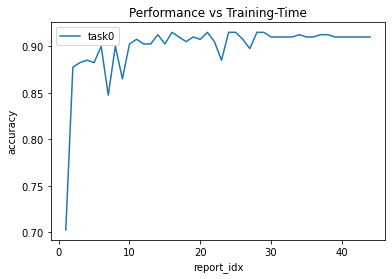

	0.915	 = Validation accuracy score
	233.56s	 = Training runtime
	1.16s	 = Validation runtime
Fitting model: WeightedEnsemble_L2 ...
	0.915	 = Validation accuracy score
	0.31s	 = Training runtime
	0.0s	 = Validation runtime
AutoGluon training complete, total runtime = 250.03s ...
TabularPredictor saved. To load, use: predictor = TabularPredictor.load("ag_tabular_product_sentiment_multimodal/")


In [7]:
from autogluon.tabular import TabularPredictor
predictor = TabularPredictor(label='Sentiment', path='ag_tabular_product_sentiment_multimodal')
predictor.fit(train_df, hyperparameters='multimodal')

In [8]:
predictor.leaderboard(dev_df)

                 model  score_test  score_val  pred_time_test  pred_time_val    fit_time  pred_time_test_marginal  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0    TextNeuralNetwork    0.904239     0.9150        3.470299       1.162980  233.556936                 3.470299                1.162980         233.556936            1       True          7
1  WeightedEnsemble_L2    0.904239     0.9150        3.488893       1.163596  233.870606                 0.018594                0.000616           0.313670            2       True          8
2        LightGBMLarge    0.888540     0.8850        0.021459       0.008472    2.711801                 0.021459                0.008472           2.711801            1       True          6
3       NeuralNetMXNet    0.886970     0.8825        0.054418       0.040689    2.378979                 0.054418                0.040689           2.378979            1       True          1
4             LightGBM    0.885400     0

,model,score_test,score_val,pred_time_test,pred_time_val,fit_time,pred_time_test_marginal,pred_time_val_marginal,fit_time_marginal,stack_level,can_infer,fit_order
0,TextNeuralNetwork,0.904239,0.9150,3.470299,1.162980,233.556936,3.470299,1.162980,233.556936,1,True,7
1,WeightedEnsemble_L2,0.904239,0.9150,3.488893,1.163596,233.870606,0.018594,0.000616,0.313670,2,True,8
2,LightGBMLarge,0.888540,0.8850,0.021459,0.008472,2.711801,0.021459,0.008472,2.711801,1,True,6
3,NeuralNetMXNet,0.886970,0.8825,0.054418,0.040689,2.378979,0.054418,0.040689,2.378979,1,True,1
4,LightGBM,0.885400,0.8875,0.009267,0.006310,1.286875,0.009267,0.006310,1.286875,1,True,2
5,CatBoost,0.885400,0.8825,0.018871,0.018485,0.713966,0.018871,0.018485,0.713966,1,True,4
6,XGBoost,0.882261,0.8925,0.130883,0.010567,1.337045,0.130883,0.010567,1.337045,1,True,5
7,LightGBMXT,0.868132,0.8625,0.010914,0.006608,0.855038,0.010914,0.006608,0.855038,1,True,3


## Improve the Performance with Stack Ensemble

You can improve predictive performance by using stack ensembling. One way to turn it on is as follows:

```
predictor.fit(train_df, hyperparameters='multimodal', num_bag_folds=5, num_stack_levels=1)
```

or using:

```
predictor.fit(train_df, hyperparameters='multimodal', presets='best_quality')
```

which will automatically select values for `num_stack_levels` (how many stacking layers) and `num_bag_folds` (how many folds to split data into during bagging).
Stack ensembling can take much longer, so we won't run with this configuration here. You may explore more examples in https://github.com/awslabs/autogluon/tree/master/examples/text_prediction, which demonstrate how you can achieve top performance in competitions with a stack ensembling based solution.